In [1]:
import pandas as pd
import xml.etree.ElementTree as et
import re,time
from bs4 import BeautifulSoup
import sqlite3
import numpy as np
import pygtrie
from matplotlib import pyplot as plt

In [2]:
def getColumns(xml_str):
    return [re.sub(r"[\n\t\s]*", "", part) for part in xml_str.split('-')]

In [3]:
user_cols = getColumns('''Id
     - Reputation
     - CreationDate
     - DisplayName
     - EmailHash
     - LastAccessDate
     - WebsiteUrl
     - Location
     - Age
     - AboutMe
     - Views
     - UpVotes
     - DownVotes''')
post_cols = getColumns('''Id
       - PostTypeId
       - ParentID
       - AcceptedAnswerId
       - CreationDate
       - Score
       - ViewCount
       - Body
       - OwnerUserId
       - LastEditorUserId
       - LastEditorDisplayName
       - LastEditDate
       - LastActivityDate
       - CommunityOwnedDate
       - ClosedDate
       - Title
       - Tags
       - AnswerCount
       - CommentCount
       - FavoriteCount''')
comment_cols= getColumns('''Id
       - PostId
       - Score
       - Text
       - CreationDate
       - UserId''')
badges_cols = getColumns('''UserId
       - Name
       - Date''')
posthistory_cols = getColumns('''Id
- PostHistoryTypeId
- PostId
- RevisionGUID
- CreationDate
- UserId
- UserDisplayName
- Comment
    - Text
- CloseReasonId''')
postlinks_cols = getColumns('''Id
     - CreationDate
     - PostId
     - RelatedPostId
     - PostLinkTypeId''')
votes_cols = getColumns('''Id
     - PostId
     - VoteTypeId
     - CreationDate
     - UserId
     - BountyAmount''')
tags_cols = ['TagName','Count','ExcerptPostId','WikiPostId']

In [4]:
def getDataFrame(file, cols, html_clean_cols):
    xtree = et.parse(file)
    root = xtree.getroot()
    rows = []
    html_clean_cols = set(html_clean_cols)
    for node in root:
        row = []
        for col in cols:
            if node is not None and node.attrib.get(col) is not None: 
                if col in html_clean_cols:
                    row.append(BeautifulSoup(node.attrib.get(col)).get_text())
                else:
                    row.append(node.attrib.get(col))
            else:
                row.append(None)
        rows.append({col: row[i] for i, col in enumerate(cols)})
    return pd.DataFrame(rows, columns=cols)

In [5]:
df_user = getDataFrame('Users.xml',user_cols,['AboutMe'])
df_post = getDataFrame('Posts.xml',post_cols,[])
df_comment = getDataFrame('Comments.xml', comment_cols,[])
df_badges = getDataFrame('Badges.xml', badges_cols, [])
df_post_history = getDataFrame('PostHistory.xml', posthistory_cols, [])
df_tags = getDataFrame('Tags.xml', tags_cols, [])
df_post_links = getDataFrame('PostLinks.xml', postlinks_cols, [])
df_votes = getDataFrame('Votes.xml', votes_cols, [])


C:\Users\Rajnish\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Rajnish\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [6]:
df_badges[df_badges['UserId']=='8820']

,UserId,Name,Date
4677,8820,Autobiographer,2015-03-25T19:49:25.950
5486,8820,Teacher,2015-05-13T03:57:46.727
5487,8820,Editor,2015-05-13T05:07:25.720
6241,8820,Supporter,2015-06-13T11:14:53.793
6254,8820,Student,2015-06-13T18:20:30.517
...,...,...,...
79503,8820,Notable Question,2019-09-24T14:30:11.823
79539,8820,Good Answer,2019-09-25T04:15:27.313
79920,8820,Notable Question,2019-10-01T22:55:11.927
80778,8820,Popular Question,2019-10-17T03:15:15.033


In [7]:
df_user.columns
df_post.Score = pd.to_numeric(df_post.Score, errors='coerce').fillna(0).astype(np.int64)
df_comment.Score = pd.to_numeric(df_comment.Score, errors='coerce').fillna(0).astype(np.int64)
df_post['CreationDate'] = pd.to_datetime(df_post['CreationDate'])

In [8]:

tag_map = []
df_post.iloc[1]['Tags'].split('<')
trie = pygtrie.CharTrie()
for i, row in df_post.iterrows():
    if row['Tags'] is None:
        continue
    tags = row['Tags'].split('<')
    tags = tags[1:]
    for tag in tags:
        if tag[:-1] in trie:
            trie[tag[:-1]].add(row['Id'])
        else:
            trie[tag[:-1]] = set([row['Id']])
        if tag[:-1] in df_tags['TagName'].values:
            tag_map.append({'Id': row['Id'], 'tagId': tag[:-1]})
df_tag_map = pd.DataFrame(tag_map, columns=['Id','tagId'])


In [9]:
con = sqlite3.connect('test.db')
cur = con.cursor()
df_tag_map.to_sql(name='tag_map', if_exists='replace', con=con)

In [10]:
pp = 0
if pp == 1:
    df_user.to_sql(name='user', if_exists='replace', con=con)
    df_post.to_sql(name='post', if_exists='replace',con=con)
    df_comment.to_sql(name='comment', if_exists='replace',con=con)
    df_badges.to_sql(name='badges', if_exists='replace',con=con)
    df_post_history.to_sql(name='post_history', if_exists='replace',con=con)
    df_tags.to_sql(name='tags', if_exists='replace',con=con)
    df_post_links.to_sql(name='post_links',if_exists='replace', con=con)
    df_votes.to_sql(name='votes', if_exists='replace',con=con)

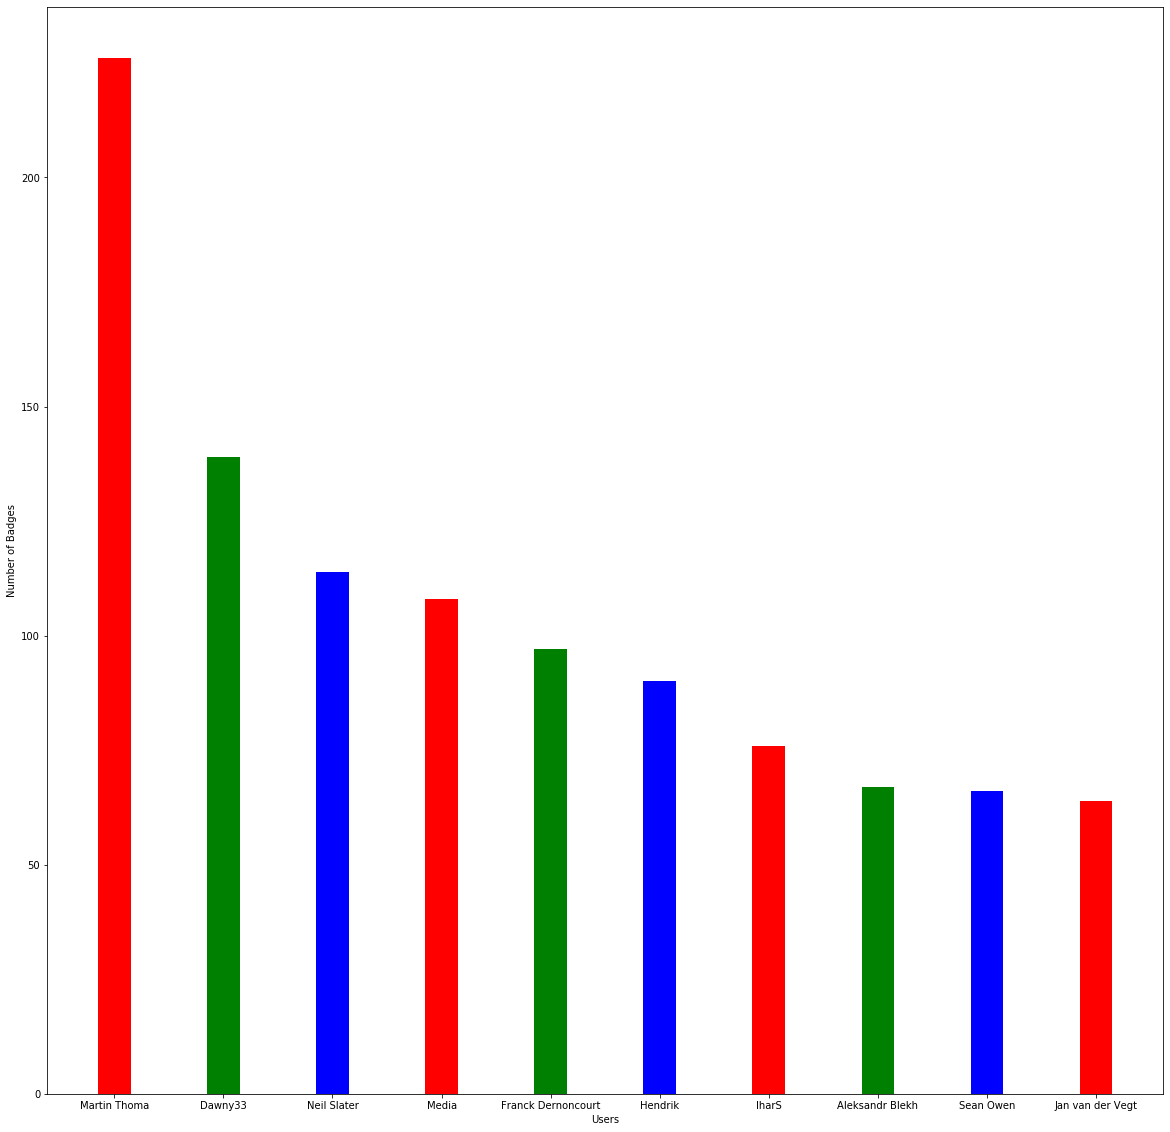

In [11]:
plt.rcParams['figure.figsize'] = [20,20]
cur.execute('''select count(UserID) as No_of_badges, UserID  from badges group by UserId order by No_of_badges desc limit 10;''')
rows = cur.fetchall()
col=['No_of_badges','UserId']
df_bad=pd.DataFrame(rows,columns=col)
df_new=pd.merge(df_bad, df_user, left_on='UserId', right_on='Id')
fig = plt.figure()
ax = plt.subplot(111)
w = 0.3
ax.bar(df_new['DisplayName'], df_new['No_of_badges'], width=w, color='rgb', align='center')
ax.autoscale(tight=False)
plt.xticks(rotation=0)
plt.ylabel("Number of Badges")
plt.xlabel("Users")
plt.show()
fig.savefig('Most active users')


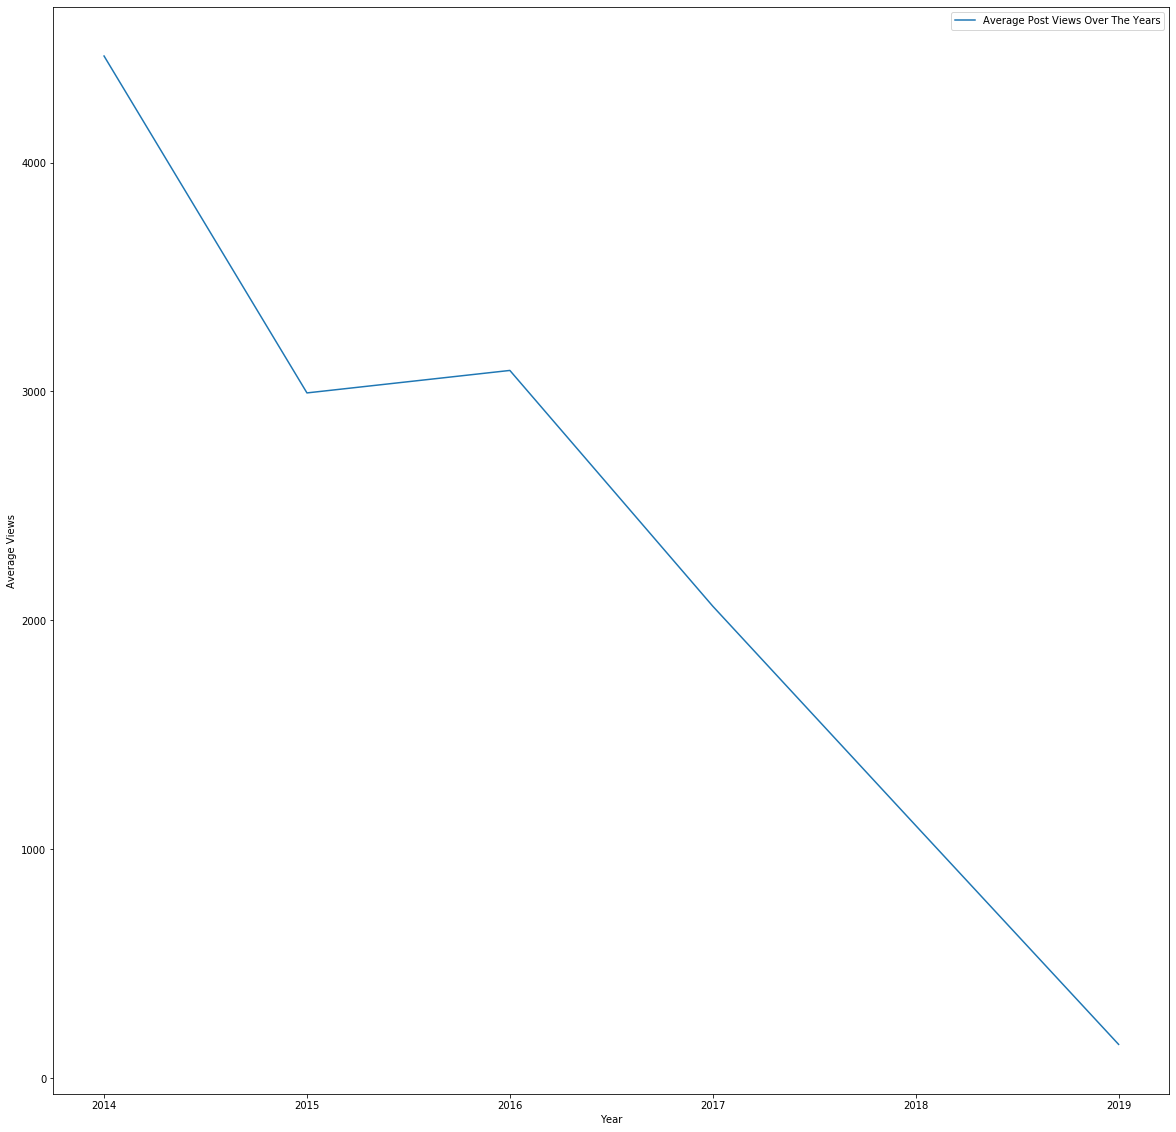

In [12]:
plt.rcParams['figure.figsize'] = [20,20]
cur.execute('''select avg(ViewCount) as avgViewCount,(select strftime('%Y', CreationDate)) as year from post group by year order by year asc;''')
rows = cur.fetchall()
col=['avgViewCount','year']
df_viewcount=pd.DataFrame(rows,columns=col)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(df_viewcount['year'], df_viewcount['avgViewCount'], label='Average Post Views Over The Years')
ax1.legend(loc=1)

plt.ylabel("Average Views")
plt.xlabel("Year")
plt.show()
fig.savefig('Average_views')

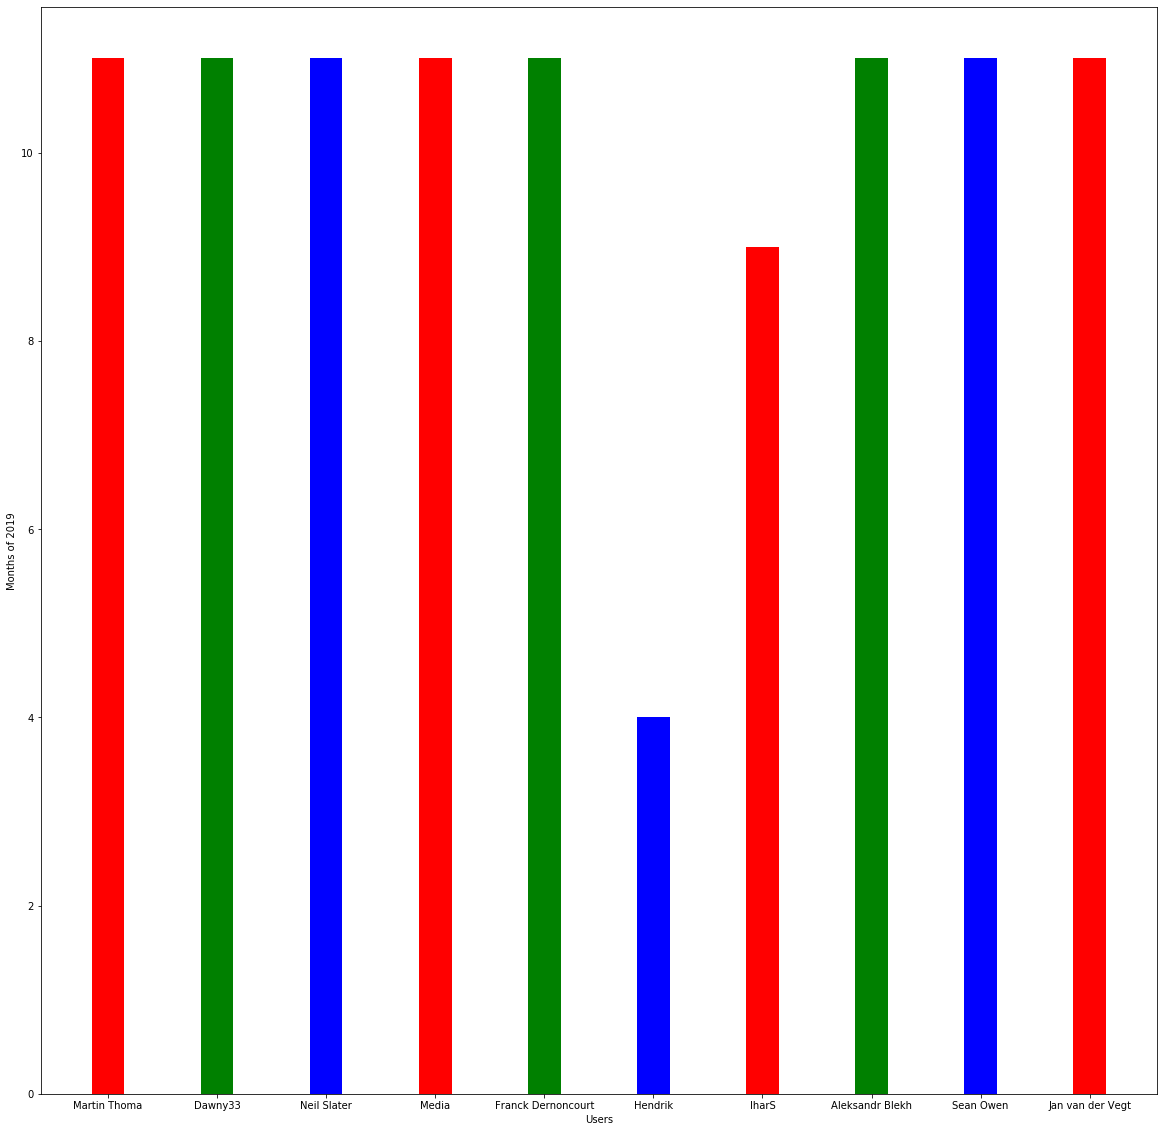

In [24]:
df_new['LastAccessDate'] = pd.to_datetime(df_new['LastAccessDate'])
fig = plt.figure()
ax = plt.subplot(111)
w = 0.3
ax.bar(df_new['DisplayName'], df_new['LastAccessDate'].dt.month, width=w, color='rgb', align='center')
ax.autoscale(tight=False)
plt.xticks(rotation=0)
plt.ylabel("Months of 2019")
plt.xlabel("Users")
plt.show()






In [21]:
df_post.head(20)

,Id,PostTypeId,ParentID,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,CommunityOwnedDate,ClosedDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,5,1,None,None,2014-05-13 23:58:30.457,8,643,<p>I've always been interested in machine lear...,5,None,None,None,2014-05-14T00:36:31.077,None,2014-05-14T14:40:25.950,How can I do simple machine learning without h...,<machine-learning>,1,1,1
1,7,1,None,10,2014-05-14 00:11:06.457,4,429,"<p>As a researcher and instructor, I'm looking...",36,97,None,2014-05-16T13:45:00.237,2014-05-16T13:45:00.237,None,2014-05-14T08:40:54.950,What open-source books (or other materials) pr...,<education><open-source>,3,4,1
2,9,2,None,None,2014-05-14 00:36:31.077,5,None,"<p>Not sure if this fits the scope of this SE,...",51,None,None,None,2014-05-14T00:36:31.077,None,None,None,None,None,0,None
3,10,2,None,None,2014-05-14 00:53:43.273,12,None,"<p>One book that's freely available is ""The El...",22,None,None,None,2014-05-14T00:53:43.273,None,None,None,None,None,1,None
4,14,1,None,29,2014-05-14 01:25:59.677,22,1542,<p>I am sure data science as will be discussed...,66,322,None,2014-06-17T16:17:20.473,2014-06-20T17:36:05.023,None,None,Is Data Science the Same as Data Mining?,<data-mining><definitions>,4,1,6
5,15,1,None,None,2014-05-14 01:41:23.110,1,636,<p>In which situations would one system be pre...,64,None,None,None,2014-05-14T01:41:23.110,None,2014-05-14T07:41:49.437,What are the advantages and disadvantages of S...,<databases>,0,1,None
6,16,1,None,46,2014-05-14 01:57:56.880,16,350,"<p>I use <a href=""http://www.csie.ntu.edu.tw/~...",63,84,None,2014-05-17T16:24:14.523,2014-05-17T16:24:14.523,None,None,Use liblinear on big data for semantic analysis,<machine-learning><bigdata><libsvm>,2,0,None
7,17,5,None,None,2014-05-14 02:49:14.580,0,None,"<p><a href=""http://www.csie.ntu.edu.tw/~cjlin/...",63,63,None,2014-05-16T13:44:53.470,2014-05-16T13:44:53.470,None,None,None,None,None,0,None
8,18,4,None,None,2014-05-14 02:49:14.580,0,None,,-1,-1,None,2014-05-14T02:49:14.580,2014-05-14T02:49:14.580,None,None,None,None,None,0,None
9,19,1,None,37,2014-05-14 03:56:20.963,86,13211,<p>Lots of people use the term <em>big data</e...,84,10119,None,2015-06-11T20:15:28.720,2018-05-01T13:04:43.563,None,None,How big is big data?,<bigdata><scalability><efficiency><performance>,12,5,25


TypeError: 'CharTrie' object is not callable